# Integrating INE and EU Datasets for Power BI Reporting

MBDS Universidad de Navarra 2023/2024. <br>
Paula Sanjuan Campos<br>

Build an entire pipe-line combining 2 different sources and output to Power BI service. For this, you will choose 2 tables. Table A from INE and table B from UE. You will later combine in the common field, preferably, `date`.

## __1. Extract data from table A directly from INE using python__

You can use the notebook "State_Stats"

In [1]:
import pandas as pd
import requests
import json

In [2]:
url = 'https://servicios.ine.es/wstempus/jsCache/es/DATOS_TABLA/46682?tip=AM&'

r = requests.get(url)
data = r.json()

The relevant information is in data[0] and data[1], which are the total and the accumulated values at national level.

In [3]:
# Selection of variables:
# dates = [item['Fecha'] for item in data[0]['Data']]
values_total = [item['Valor'] for item in data[0]['Data']]
year = [item['Anyo'] for item in data[0]['Data']]
values_acum = [item['Valor'] for item in data[1]['Data']]


# df = pd.DataFrame({'Date': pd.to_datetime(dates), 'Spanish total value': values_year, 'Year': anyo, 'Spanish accum value': values_acum})
df = pd.DataFrame({'Spanish total value': values_total, 'Year': year})
# Sort the dataframe by date
df = df.sort_values(by='Year')

# Reset the index
df = df.reset_index(drop=True)
df

,Spanish total value,Year
0,34333.0,2016
1,32943.0,2016
2,33181.0,2016
3,35533.0,2016
4,35996.0,2016
...,...,...
90,26451.0,2023
91,24499.0,2023
92,27013.0,2023
93,26363.0,2023


The preprocessing of this dataframe consists of grouping the rows that are records of the same year. Then it is grouped by years and the 'Year' column is set as the index of the dataframe. 

In [4]:
df1 = df.groupby('Year').sum().reset_index()
df1.set_index('Year', inplace=True)
df1

,Spanish total value
Year,
2016,408734.0
2017,391265.0
2018,370827.0
2019,358747.0
2020,340635.0
2021,336823.0
2022,328704.0
2023,294856.0


## __2. Extract data from table B directly from UE using python__

In [5]:
# !pip install eurostat

In [6]:
import eurostat

In [7]:
eurostat_code = 'demo_fabortord'
data_list = eurostat.get_data(eurostat_code)

df2 = pd.DataFrame(data_list)
df2.columns = df2.iloc[0]
df2.drop(df2.index[0], axis=0, inplace=True)
df2.head()

,freq,unit,age,ord_brth,geo\TIME_PERIOD,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,A,NR,TOTAL,0,AL,None,None,None,None,None,None,None,None,None,None,267.0,249.0,243.0,178.0,None
2,A,NR,TOTAL,0,BE,8721.0,8740.0,8833.0,8851.0,9145.0,None,None,None,None,None,None,None,None,None,None
3,A,NR,TOTAL,0,BY,None,None,None,None,None,None,4784.0,4426.0,None,None,None,None,None,None,None
4,A,NR,TOTAL,0,CH,1886.0,2000.0,2109.0,2210.0,2073.0,2133.0,2054.0,2660.0,1960.0,1947.0,1902.0,2544.0,1860.0,2606.0,None
5,A,NR,TOTAL,0,CZ,7129.0,7452.0,7110.0,6717.0,6742.0,6503.0,6536.0,6199.0,5701.0,5915.0,5706.0,5279.0,4976.0,4663.0,4400.0


The preprocessing of this second dataframe will consist of: 
- Adapting the name of the columns
- Delete the columns that do not provide information (check which of them have important values). Finally, the 'freq', 'unit' columns are eliminated. In addition, the records for which all ages have been considered, where 'age' == 'TOTAL' and the records for which 'ord_brth'=='TOTAL' are selected. 
- As in the previous dataframe, records are grouped by country ('geo'). 
- We obtain the transpose so that the indexes are dates (years)

In [8]:
column_map = {'geo\\TIME_PERIOD': 'geo'}
df2 = df2.rename(columns=column_map)
df2.head()

,freq,unit,age,ord_brth,geo,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,A,NR,TOTAL,0,AL,None,None,None,None,None,None,None,None,None,None,267.0,249.0,243.0,178.0,None
2,A,NR,TOTAL,0,BE,8721.0,8740.0,8833.0,8851.0,9145.0,None,None,None,None,None,None,None,None,None,None
3,A,NR,TOTAL,0,BY,None,None,None,None,None,None,4784.0,4426.0,None,None,None,None,None,None,None
4,A,NR,TOTAL,0,CH,1886.0,2000.0,2109.0,2210.0,2073.0,2133.0,2054.0,2660.0,1960.0,1947.0,1902.0,2544.0,1860.0,2606.0,None
5,A,NR,TOTAL,0,CZ,7129.0,7452.0,7110.0,6717.0,6742.0,6503.0,6536.0,6199.0,5701.0,5915.0,5706.0,5279.0,4976.0,4663.0,4400.0


In [9]:
print('Freq values: ', df2['freq'].unique())
print('Age values: ', df2['age'].unique())
print('Ord_brth values: ', df2['ord_brth'].unique())
print('Unit values: ', df2['unit'].unique())
print('Geo values: ', df2['geo'].unique())

Freq values:  ['A']
Age values:  ['TOTAL' 'UNK' 'Y15-19' 'Y20-24' 'Y25-29' 'Y30-34' 'Y35-39' 'Y40-44'
 'Y45-49' 'Y_GE50' 'Y_LT15']
Ord_brth values:  ['0' '1' '2' '3' '4' '5' 'GE6' 'TOTAL' 'UNK']
Unit values:  ['NR']
Geo values:  ['AL' 'BE' 'BY' 'CH' 'CZ' 'DE' 'DE_TOT' 'EE' 'ES' 'FI' 'HR' 'HU' 'IS' 'IT'
 'LT' 'PT' 'RO' 'RS' 'SE' 'SI' 'SK' 'AM' 'AZ' 'BG' 'DK' 'FR' 'FX' 'GE'
 'LV' 'MD' 'ME' 'PL' 'RU' 'SM' 'UA' 'UK' 'IE']


In [10]:
df2.drop('freq', axis=1, inplace=True)
df2.drop('unit', axis=1, inplace=True)
df2.query("age == 'TOTAL'")
df2.drop('age', axis=1, inplace=True)
df2 = df2[df2['ord_brth'] == 'TOTAL']
df2.drop('ord_brth', axis=1, inplace=True)
df2.head()

,geo,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
133,AL,None,None,None,None,None,None,None,5572.0,5619.0,None,1000.0,1147.0,837.0,873.0,None
134,AM,11501.0,12469.0,13797.0,None,None,None,None,11892.0,11104.0,10448.0,10006.0,10404.0,10892.0,10718.0,None
135,AZ,22323.0,None,24554.0,26799.0,None,31037.0,27892.0,27220.0,27452.0,34569.0,34569.0,36141.0,37299.0,34712.0,None
136,BE,18033.0,18304.0,18870.0,19095.0,19578.0,None,None,None,None,None,None,None,None,None,None
137,BG,37594.0,36593.0,33733.0,31548.0,31716.0,29992.0,29505.0,28145.0,27782.0,26412.0,24287.0,23437.0,21864.0,19328.0,19353.0


In [11]:
grouped_df2 = df2.groupby('geo').sum().reset_index()
# grouped_df2.set_index('geo', inplace=True)
grouped_df2.head()


,geo,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AL,0,0,0,0,0,0,0,5572.0,5619.0,0,2000.0,2294.0,1674.0,1746.0,0
1,AM,11501.0,24938.0,27594.0,0,0,0,0,23784.0,11104.0,20896.0,20012.0,20808.0,21784.0,10718.0,0
2,AZ,44646.0,0,24554.0,53598.0,0,62074.0,55784.0,54440.0,54904.0,69138.0,63871.0,72282.0,37299.0,34712.0,0
3,BE,36066.0,36608.0,37740.0,38190.0,39156.0,0,0,0,0,0,0,0,0,0,0
4,BG,75188.0,73186.0,67466.0,63096.0,63432.0,59984.0,59010.0,56290.0,55564.0,52824.0,48574.0,46874.0,43728.0,38656.0,38706.0


In [12]:
df2_final = grouped_df2.T
df2_final.columns = df2_final.iloc[0]
df2_final = df2_final[1:]
df2_final.index.name = 'Year'
df2_final.index = df2_final.index.astype('int64')
df2_final.index

Index([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021],
      dtype='int64', name='Year')

__3. Join both tables using the common field__

You can use `merge` or `concat`

In [13]:
df1.index

Index([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype='int64', name='Year')

In [14]:
df2_final.index

Index([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021],
      dtype='int64', name='Year')

In [15]:
df_merged = df1.merge(df2_final, on='Year')
df_merged

,Spanish total value,AL,AM,AZ,BE,BG,BY,CH,CZ,DE,...,PT,RO,RS,RU,SE,SI,SK,SM,UA,UK
Year,,,,,,,,,,,,,,,,,,,,,
2016,408734.0,0,20896.0,69138.0,0,52824.0,54934.0,20170.0,40812.0,197442.0,...,31918.0,127036.0,0,0,0,7472.0,18780.0,0,0,395318.0
2017,391265.0,2000.0,20012.0,63871.0,0,48574.0,50498.0,19726.0,38830.0,202418.0,...,30984.0,112476.0,20756.0,0,0,7058.0,18164.0,0,189330.0,0
2018,370827.0,2294.0,20808.0,72282.0,0,46874.0,46610.0,20526.0,36596.0,201972.0,...,29856.0,104636.0,19964.0,0,0,6948.0,18078.0,0,173356.0,0
2019,358747.0,1674.0,21784.0,37299.0,0,43728.0,0,18138.0,35514.0,201786.0,...,30528.0,94984.0,19686.0,0,0,6550.0,13364.0,0,159124.0,0
2020,340635.0,1746.0,10718.0,34712.0,0,38656.0,0,21550.0,33772.0,199896.0,...,28150.0,63778.0,16010.0,0,0,5890.0,12360.0,0.0,129786.0,0
2021,336823.0,0,0,0,0,38706.0,0,0,30984.0,189192.0,...,27922.0,58528.0,17010.0,0,0,5852.0,11104.0,0,110312.0,0


In [16]:
columns_without_zeros = df_merged.columns[(df_merged != 0).all(axis=0)]
df_reduced = df_merged[columns_without_zeros]
df_reduced

,Spanish total value,BG,CZ,DE,FI,HR,HU,LT,LV,PT,RO,SI,SK
Year,,,,,,,,,,,,,
2016,408734.0,52824.0,40812.0,197442.0,18774.0,5040.0,60878.0,9004.0,8732.0,31918.0,127036.0,7472.0,18780.0
2017,391265.0,48574.0,38830.0,202418.0,18664.0,4832.0,56992.0,8588.0,7834.0,30984.0,112476.0,7058.0,18164.0
2018,370827.0,46874.0,36596.0,201972.0,17196.0,5116.0,53882.0,7180.0,7272.0,29856.0,104636.0,6948.0,18078.0
2019,358747.0,43728.0,35514.0,201786.0,17414.0,5406.0,51566.0,6392.0,6734.0,30528.0,94984.0,6550.0,13364.0
2020,340635.0,38656.0,33772.0,199896.0,16644.0,5188.0,47802.0,5588.0,5696.0,28150.0,63778.0,5890.0,12360.0
2021,336823.0,38706.0,30984.0,189192.0,15080.0,5342.0,43814.0,5470.0,2698.0,27922.0,58528.0,5852.0,11104.0


__4. Create a calculated field named "pred_place_holder"__

You can create a dummy column of `ones`. This step is to ilustrate "the magic goes here"

In [17]:
df_reduced['pred_place_holder'] =1
df_reduced = df_reduced.reset_index()
df_reduced

C:\Users\bysan\AppData\Local\Temp\ipykernel_6492\3804959263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['pred_place_holder'] =1


,Year,Spanish total value,BG,CZ,DE,FI,HR,HU,LT,LV,PT,RO,SI,SK,pred_place_holder
0,2016,408734.0,52824.0,40812.0,197442.0,18774.0,5040.0,60878.0,9004.0,8732.0,31918.0,127036.0,7472.0,18780.0,1
1,2017,391265.0,48574.0,38830.0,202418.0,18664.0,4832.0,56992.0,8588.0,7834.0,30984.0,112476.0,7058.0,18164.0,1
2,2018,370827.0,46874.0,36596.0,201972.0,17196.0,5116.0,53882.0,7180.0,7272.0,29856.0,104636.0,6948.0,18078.0,1
3,2019,358747.0,43728.0,35514.0,201786.0,17414.0,5406.0,51566.0,6392.0,6734.0,30528.0,94984.0,6550.0,13364.0,1
4,2020,340635.0,38656.0,33772.0,199896.0,16644.0,5188.0,47802.0,5588.0,5696.0,28150.0,63778.0,5890.0,12360.0,1
5,2021,336823.0,38706.0,30984.0,189192.0,15080.0,5342.0,43814.0,5470.0,2698.0,27922.0,58528.0,5852.0,11104.0,1


__5. Push the resulting df to Power BI service__

You can use the notebook "Idealista"

In [18]:
# Variable types
df_reduced.dtypes

Year                     int64
Spanish total value    float64
BG                      object
CZ                      object
DE                      object
FI                      object
HR                      object
HU                      object
LT                      object
LV                      object
PT                      object
RO                      object
SI                      object
SK                      object
pred_place_holder        int64
dtype: object

In [19]:
# Configure every variable type as 'int64'
df_final = df_reduced.apply(pd.to_numeric, errors='coerce').fillna(0).astype('int64')
df_final.dtypes

Year                   int64
Spanish total value    int64
BG                     int64
CZ                     int64
DE                     int64
FI                     int64
HR                     int64
HU                     int64
LT                     int64
LV                     int64
PT                     int64
RO                     int64
SI                     int64
SK                     int64
pred_place_holder      int64
dtype: object

Convert the dataframe into a dictionary where each list item will be a dictionary representing a row of the DataFrame, where the keys are the names of the columns and the values are the values of the cells corresponding to those columns in that specific row.

In [20]:
dict_final = df_final.to_dict(orient='records')
dict_final

[{'Year': 2016,
  'Spanish total value': 408734,
  'BG': 52824,
  'CZ': 40812,
  'DE': 197442,
  'FI': 18774,
  'HR': 5040,
  'HU': 60878,
  'LT': 9004,
  'LV': 8732,
  'PT': 31918,
  'RO': 127036,
  'SI': 7472,
  'SK': 18780,
  'pred_place_holder': 1},
 {'Year': 2017,
  'Spanish total value': 391265,
  'BG': 48574,
  'CZ': 38830,
  'DE': 202418,
  'FI': 18664,
  'HR': 4832,
  'HU': 56992,
  'LT': 8588,
  'LV': 7834,
  'PT': 30984,
  'RO': 112476,
  'SI': 7058,
  'SK': 18164,
  'pred_place_holder': 1},
 {'Year': 2018,
  'Spanish total value': 370827,
  'BG': 46874,
  'CZ': 36596,
  'DE': 201972,
  'FI': 17196,
  'HR': 5116,
  'HU': 53882,
  'LT': 7180,
  'LV': 7272,
  'PT': 29856,
  'RO': 104636,
  'SI': 6948,
  'SK': 18078,
  'pred_place_holder': 1},
 {'Year': 2019,
  'Spanish total value': 358747,
  'BG': 43728,
  'CZ': 35514,
  'DE': 201786,
  'FI': 17414,
  'HR': 5406,
  'HU': 51566,
  'LT': 6392,
  'LV': 6734,
  'PT': 30528,
  'RO': 94984,
  'SI': 6550,
  'SK': 13364,
  'pred_plac

In [21]:
# PowerBI configuration
powerbi_url = 'https://api.powerbi.com/beta/ced2c552-7d1f-4731-aa3a-2f0ec9629e26/datasets/030832a3-3abf-479a-8bdc-b8b52682d16d/rows?experience=power-bi&key=%2Ft15aR5fRC1L9CQ7R1QBHhR3trk2Y%2B1xSVU8aXgD4hW7cQrQVE377PVcAOJuaaiQwvheyd0rsVrfssbR0VN0Pg%3D%3D'
headers = {'Content-Type': 'application/json'}

In [22]:
response = requests.request(
    method="POST",
    url=powerbi_url,
    headers=headers,
    data=json.dumps(dict_final)
)
response

<Response [200]>

<!-- 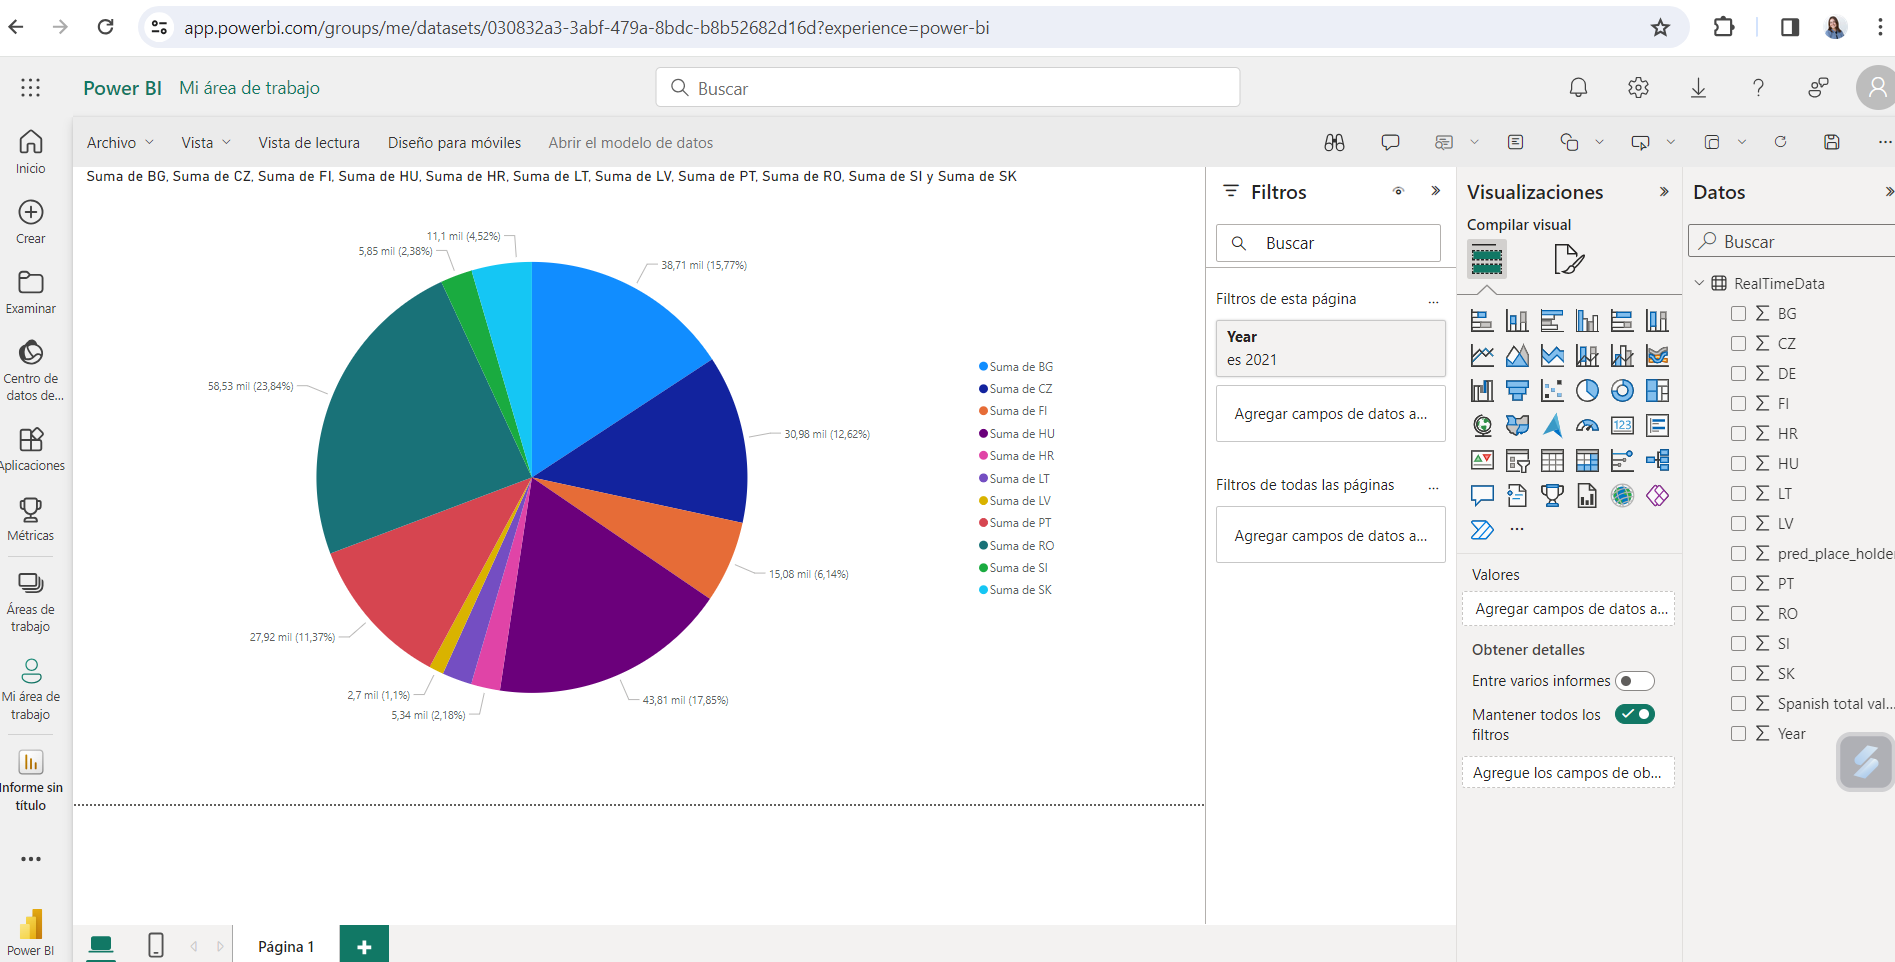 -->
<img src="powerbi.png" width="600" height="300">

__6. Paste the code you would use to automate the process using your local scheduler__

You can use the notebook "Local_deployment". You need 2 files: .py, and .bat.

6.1. Create the .py Script --> Push the DataFrame to PowerBI and create a csv file 




The following code is contained in the file *ent_2_local.py*, it includes all the code of the cells of this notebook along with the function that saves the final dataframe in *.csv* format in the same folder of the deliverable. I have left the last *.csv* obtained as a demonstration. 

In [23]:
import sys
import os

print(sys.path)
import datetime
import pandas as pd
import requests
import json
import eurostat


# 1. INE DATA
def get_inedata(url_ine):
    r = requests.get(url_ine)
    data = r.json()
    if data and 'Data' in data[0] and isinstance(data[0]['Data'], list):
        values_total = [item['Valor'] for item in data[0]['Data']]
        year = [item['Anyo'] for item in data[0]['Data']]
        df = pd.DataFrame({'Spanish total value': values_total, 'Year': year})
        return df
    else:
        print("Error: Unexpected JSON structure or missing data")
        
def ine_df(df):
    # DataFrame 1
    df = df.sort_values(by='Year')
    df = df.reset_index(drop=True)
    df1 = df.groupby('Year').sum().reset_index()
    df1.set_index('Year', inplace=True)
    return df1

# 2. Eurostat DATA
def ue_data(eurostat_code):
    data_list = eurostat.get_data(eurostat_code)
    # DataFrame 2
    df2 = pd.DataFrame(data_list)
    df2.columns = df2.iloc[0]
    df2.drop(df2.index[0], axis=0, inplace=True)
    column_map = {'geo\\TIME_PERIOD': 'geo'}
    df2 = df2.rename(columns=column_map)
    df2.drop('freq', axis=1, inplace=True)
    df2.drop('unit', axis=1, inplace=True)
    df2.query("age == 'TOTAL'")
    df2.drop('age', axis=1, inplace=True)
    df2 = df2[df2['ord_brth'] == 'TOTAL']
    df2.drop('ord_brth', axis=1, inplace=True)
    grouped_df2 = df2.groupby('geo').sum().reset_index()
    df2_final = grouped_df2.T
    df2_final.columns = df2_final.iloc[0]
    df2_final = df2_final[1:]
    df2_final.index.name = 'Year'
    df2_final.index = df2_final.index.astype('int64')
    return df2_final

# Get the data 
current_directory = os.getcwd()
file_name = 'datos_entregable_2'
time_stamp = datetime.datetime.now().strftime('%Y%m%d_h%Hm%M')
file_name = file_name + time_stamp + '.csv'
file_path = os.path.join(current_directory, file_name)

url_ine = 'https://servicios.ine.es/wstempus/jsCache/es/DATOS_TABLA/46682?tip=AM&'
data_ine = get_inedata(url_ine)
df_ine = ine_df(data_ine)

eurostat_code = 'demo_fabortord'
df_ue = ue_data(eurostat_code)

# 3. Merge DataFrames
df_merged = df_ine.merge(df_ue, on='Year')
columns_without_zeros = df_merged.columns[(df_merged != 0).all(axis=0)]
df_reduced = df_merged[columns_without_zeros]

# 4. pred_place_holder
df_reduced['pred_place_holder'] = 1
df_reduced = df_reduced.reset_index()

# 5.1. Create a csv
df_reduced.to_csv(file_path, sep=',', encoding='utf-8')

# 5. To PowerBI
df_final = df_reduced.apply(pd.to_numeric, errors='coerce').fillna(0).astype('int64')
dict_final = df_final.to_dict(orient='records')
powerbi_url = 'https://api.powerbi.com/beta/ced2c552-7d1f-4731-aa3a-2f0ec9629e26/datasets/030832a3-3abf-479a-8bdc-b8b52682d16d/rows?experience=power-bi&key=%2Ft15aR5fRC1L9CQ7R1QBHhR3trk2Y%2B1xSVU8aXgD4hW7cQrQVE377PVcAOJuaaiQwvheyd0rsVrfssbR0VN0Pg%3D%3D'
headers = {'Content-Type': 'application/json'}
response = requests.request(
    method="POST",
    url=powerbi_url,
    headers=headers,
    data=json.dumps(dict_final)
)
print(response)


['c:\\Users\\bysan\\OneDrive\\Escritorio\\Paula\\MBDS\\Recogida_datos\\paula_sanjuan_campos', 'c:\\Users\\bysan\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'c:\\Users\\bysan\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'c:\\Users\\bysan\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'c:\\Users\\bysan\\AppData\\Local\\Programs\\Python\\Python312', '', 'C:\\Users\\bysan\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\bysan\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\bysan\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\bysan\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'c:\\Users\\bysan\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages']


C:\Users\bysan\AppData\Local\Temp\ipykernel_6492\1598379733.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop('ord_brth', axis=1, inplace=True)
C:\Users\bysan\AppData\Local\Temp\ipykernel_6492\1598379733.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['pred_place_holder'] = 1


<Response [200]>


For the automatic execution of the code, I have also created the *file ent_2_local.bat* which, when executed, triggers the code written before and generates a new *.csv*. This *.bat* file, has been made in such a way that when executed, it generates a new virtual environment in which the dependencies determined by the text file 'requirements.txt' are installed. In addition, if any error occurs, it is reflected in the *output.log* file. The content of this file is: 

@echo off <br>
REM Set the current working directory to the directory containing the batch script <br>
cd /d "%~dp0" <br>
REM Set up the virtual environment<br>
python -m venv venv<br>
call venv\Scripts\activate.bat<br>
REM Install dependencies<br>
pip install -r requirements.txt<br>
REM Run the Python script<br>
echo Executing command: python ent_2_local.py<br>
python ent_2_local.py > output.log 2>&1<br>
REM Display a message indicating the script has finished<br>
echo Script execution completed. Please check output.log for any errors.<br>
pause<br>
